# 📤 Importing Required Libraries¶

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import time
from datetime import datetime
from datetime import timedelta
sns.set()

# 💾 Reading Data
Can download the dataset from this link : https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data

In [2]:
train = pd.read_csv(r'C:\Users\vicky\Downloads\DelhiClimate\DailyDelhiClimateTrain.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\vicky\Downloads\DelhiClimate\DailyDelhiClimateTest.csv', parse_dates=['date'])
train.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


# 💾 Checking Out the Data

In [3]:
train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [4]:
train.isnull().sum(axis = 0)

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Now, Checking and Removing Outliers

C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\si

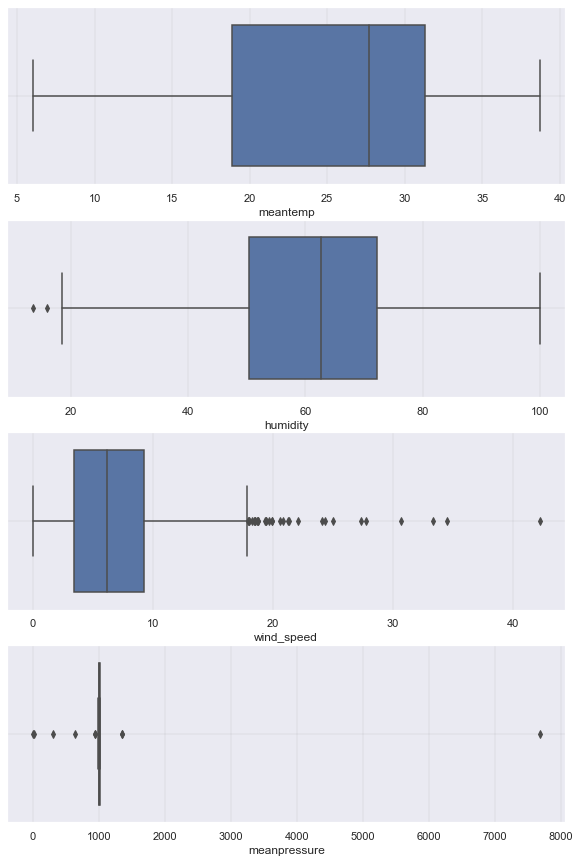

In [5]:
j=0
fig,ax=plt.subplots(4,figsize=(10,15))
for column in train.drop(['date'],axis=1):
    sns.boxplot(train[column],ax=ax[j])
    ax[j].set_xlabel(column)
    ax[j].grid(color='grey',linestyle='-',linewidth=0.25,alpha=0.5)
    j+=1

Can See,  

NO Outliers in Temperature

2 Outliers in Humidity (I'm Sure Delhi never reaches an absolute humidty level which is below 20gm per cc) and

MANY Outliers in WindSpeed (maximum wind speed ever was 28.2 that too in 2018) and

Pressure (pressure usually ranges between 900 and 1000)

# Replacing Outliers by NaN : -

In [6]:
Q1wind = np.percentile(train['wind_speed'], 25,
                   interpolation = 'midpoint')
 
Q3wind = np.percentile(train['wind_speed'], 75,
                   interpolation = 'midpoint')
IQRwind = Q3wind - Q1wind

Q1pressure = np.percentile(train['meanpressure'], 25,
                   interpolation = 'midpoint')
 
Q3pressure = np.percentile(train['meanpressure'], 75,
                   interpolation = 'midpoint')
IQRpressure = Q3pressure - Q1pressure

Q1hum = np.percentile(train['humidity'], 25,
                   interpolation = 'midpoint')
 
Q3hum = np.percentile(train['humidity'], 75,
                   interpolation = 'midpoint')
IQRhum = Q3hum - Q1hum

# Upper bound
for i in range(1462):
    if (train['wind_speed'][i] >= Q3wind+1.5*IQRwind):
        train['wind_speed'][i]=np.NaN
    if (train['meanpressure'][i] >= Q3pressure+1.5*IQRpressure or train['meanpressure'][i] <= Q1pressure-1.5*IQRpressure):
        train['meanpressure'][i]=np.NaN
    if (train['humidity'][i] <= Q1hum-1.5*IQRhum):
        train['humidity'][i]=np.NaN

<ipython-input-6-dae0395cfcd6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['wind_speed'][i]=np.NaN
<ipython-input-6-dae0395cfcd6>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['humidity'][i]=np.NaN
<ipython-input-6-dae0395cfcd6>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['meanpressure'][i]=np.NaN


To fill in the missing values we'll use Interpolation instead of just replacing them by the median or dropping them

Interpolation explanation : - https://en.wikipedia.org/wiki/Interpolation

In [7]:
train['wind_speed'] = train['wind_speed'].interpolate()
train['humidity'] = train['humidity'].interpolate()
train['meanpressure'] = train['meanpressure'].interpolate()

C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\si

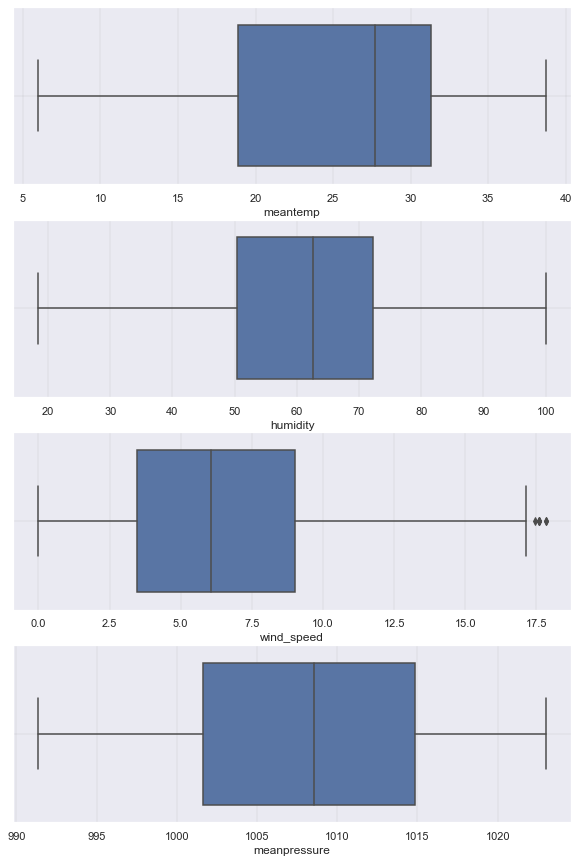

In [8]:
j=0
fig,ax=plt.subplots(4,figsize=(10,15))
for column in train.drop(['date'],axis=1):
    sns.boxplot(train[column],ax=ax[j])
    ax[j].set_xlabel(column)
    ax[j].grid(color='grey',linestyle='-',linewidth=0.25,alpha=0.5)
    j+=1

# Doing the same thing for testing data

In [9]:
test.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


In [10]:
test.isnull().sum(axis = 0)

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\si

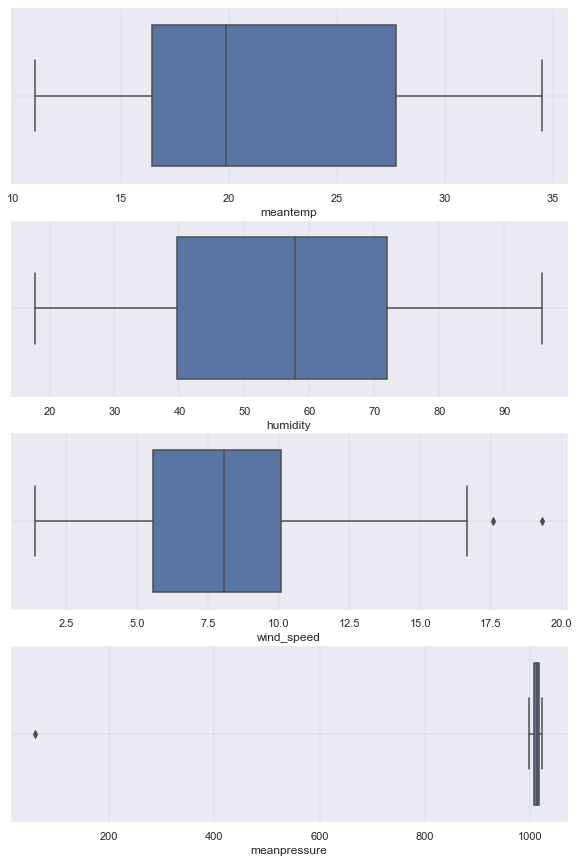

In [11]:
j=0
fig,ax=plt.subplots(4,figsize=(10,15))
for column in test.drop(['date'],axis=1):
    sns.boxplot(test[column],ax=ax[j])
    ax[j].set_xlabel(column)
    ax[j].grid(color='grey',linestyle='-',linewidth=0.25,alpha=0.5)
    j+=1

In [12]:
Q1wind = np.percentile(test['wind_speed'], 25,
                   interpolation = 'midpoint')
 
Q3wind = np.percentile(test['wind_speed'], 75,
                   interpolation = 'midpoint')
IQRwind = Q3wind - Q1wind

Q1pressure = np.percentile(test['meanpressure'], 25,
                   interpolation = 'midpoint')
 
Q3pressure = np.percentile(test['meanpressure'], 75,
                   interpolation = 'midpoint')
IQRpressure = Q3pressure - Q1pressure

# Upper bound
for i in range(114):
    if (test['wind_speed'][i] >= Q3wind+1.5*IQRwind):
        test['wind_speed'][i]=np.NaN
    if (test['meanpressure'][i] >= Q3pressure+1.5*IQRpressure or test['meanpressure'][i] <= Q1pressure-1.5*IQRpressure):
        test['meanpressure'][i]=np.NaN

<ipython-input-12-58d1050d2c79>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['meanpressure'][i]=np.NaN
<ipython-input-12-58d1050d2c79>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wind_speed'][i]=np.NaN


In [13]:
test['wind_speed'] = test['wind_speed'].interpolate()
test['meanpressure'] = test['meanpressure'].interpolate()

C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vicky\anaconda3\lib\si

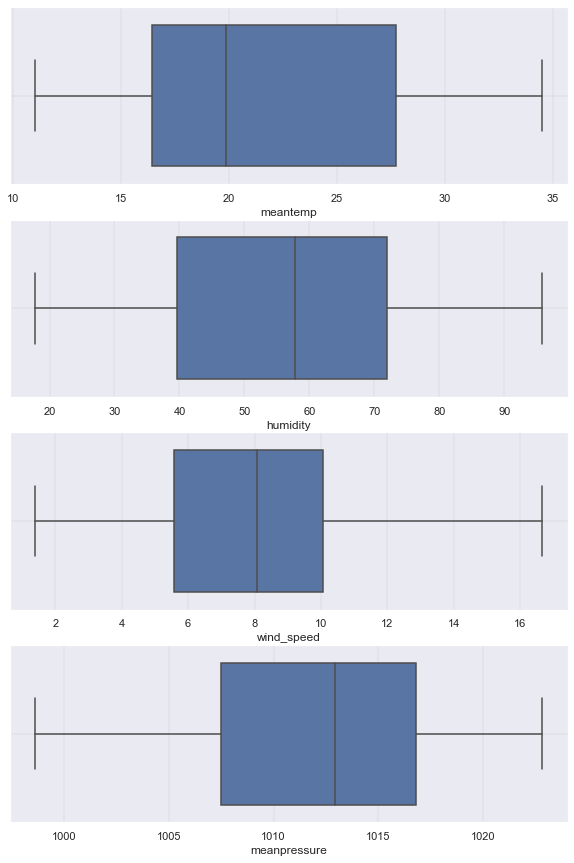

In [14]:
j=0
fig,ax=plt.subplots(4,figsize=(10,15))
for column in test.drop(['date'],axis=1):
    sns.boxplot(test[column],ax=ax[j])
    ax[j].set_xlabel(column)
    ax[j].grid(color='grey',linestyle='-',linewidth=0.25,alpha=0.5)
    j+=1

# 📊 Exploratory Data Analysis (EDA)

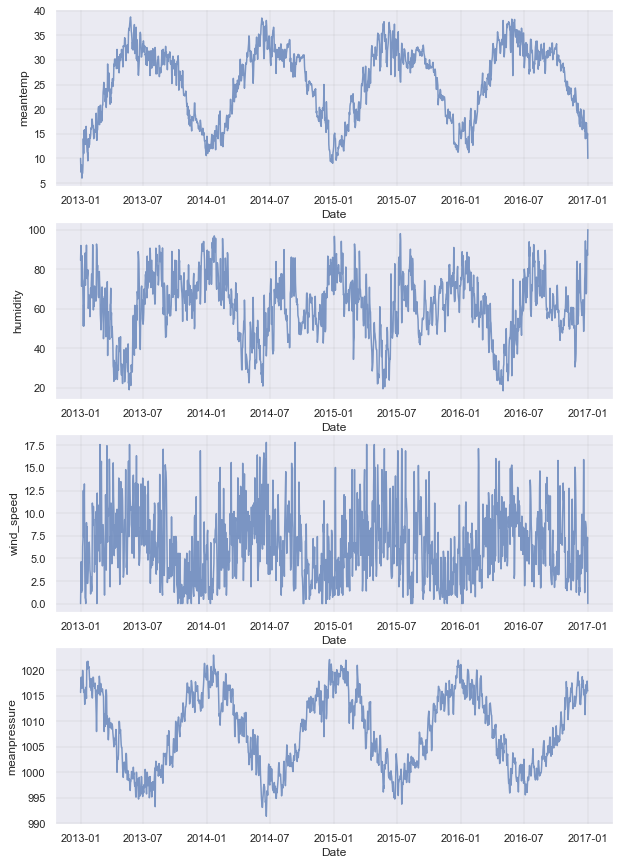

In [15]:
j=0
fig,ax=plt.subplots(4,figsize=(10,15))
for column in train.drop(['date'],axis=1):
    ax[j].plot(train['date'],train[column],alpha=0.7)
    ax[j].set_xlabel('Date')
    ax[j].set_ylabel(column)
    ax[j].grid(color='grey',linestyle='-',linewidth=0.25,alpha=0.5)
    j+=1

Looks Very Messy. Let's try to convert the daily data into weekly. That will reduce the number of data points and it will look cleaner.

In [16]:
trainWeekly = train[['date',
                 'meantemp', 
                 'humidity',
                 'wind_speed', 
                 'meanpressure']].resample('7D', on='date').mean().reset_index(drop=False)

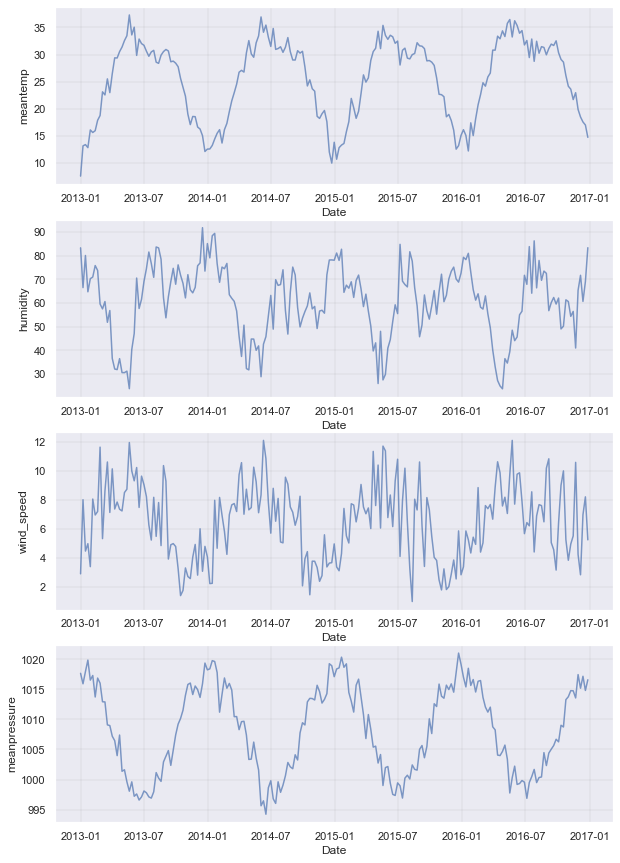

In [17]:
j=0
fig,ax=plt.subplots(4,figsize=(10,15))
for column in trainWeekly.drop(['date'],axis=1):
    ax[j].plot(trainWeekly['date'],trainWeekly[column],alpha=0.7)
    ax[j].set_xlabel('Date')
    ax[j].set_ylabel(column)
    ax[j].grid(color='grey',linestyle='-',linewidth=0.25,alpha=0.5)
    j+=1

Looks Much Better

In [18]:
testWeekly = test[['date',
                 'meantemp', 
                 'humidity',
                 'wind_speed', 
                 'meanpressure']].resample('7D', on='date').mean().reset_index(drop=False)

# Checking Correlation

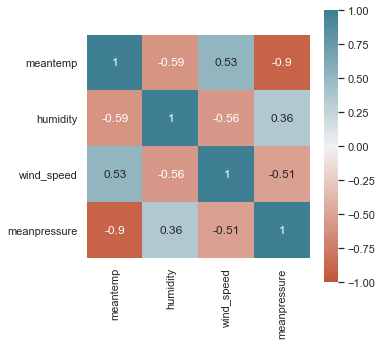

In [19]:
c=trainWeekly.corr()
fig,ax=plt.subplots(figsize=(5,5))
a=sns.heatmap(
    c,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    square=True,
    annot=True,
)

All the Correlations are Decent. Every variable seems significant.

Now, it's time to check whether our Time Series is Stationary of Not

(Some time-series models, such as such as ARMA, assume that the underlying data is stationary. Stationarity describes that the time-series has constant mean and mean is not time-dependent constant variance and variance is not time-dependent constant covariance and covariance is not time-dependent)

Let's first visualize the mean and standard deviation to get an idea of it,  later on we will run the adfuller test to get the exact results

<ipython-input-20-5a03af052caf>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(trainWeekly['meantemp'], freq=52, model='additive', extrapolate_trend='freq')


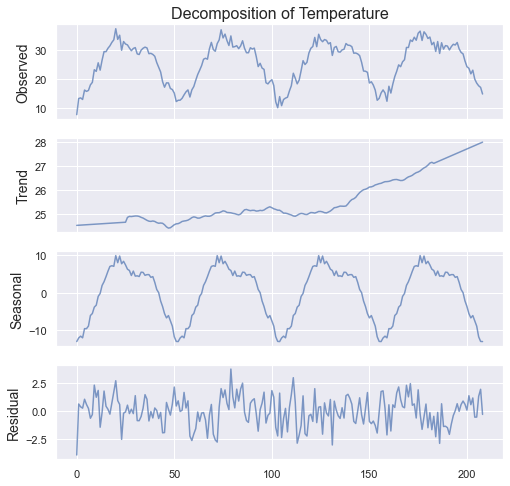

In [20]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,8))

res = seasonal_decompose(trainWeekly['meantemp'], freq=52, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0], legend=False,alpha=0.7)
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False,alpha=0.7)
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False,alpha=0.7)
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False,alpha=0.7)
ax[3].set_ylabel('Residual', fontsize=14) 

plt.show()

Definately a linear upward trend (almost multiplicative) and obvious visible seasonality

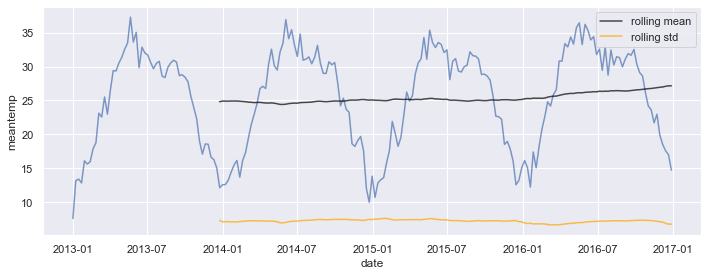

In [21]:
rolling_window = 52
fig,ax=plt.subplots(figsize=(10,4))
sns.lineplot(x=trainWeekly['date'], y=trainWeekly['meantemp'], ax=ax,alpha=0.7)
sns.lineplot(x=trainWeekly['date'], y=trainWeekly['meantemp'].rolling(rolling_window).mean(), ax=ax,alpha=0.7, color='black', label='rolling mean')
sns.lineplot(x=trainWeekly['date'], y=trainWeekly['meantemp'].rolling(rolling_window).std(), ax=ax,alpha=0.7, color='orange', label='rolling std')
plt.tight_layout()
plt.show()

The trend of mean and standard deviation looks approximately linear (with a little upward trend in mean and a little downwards in humidity)

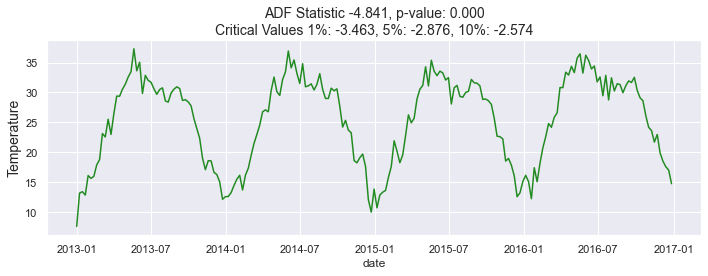

In [22]:
result = adfuller(trainWeekly['meantemp'].values)
## running the adfuller function to get the actual results
f, ax = plt.subplots(figsize=(10, 4))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=trainWeekly['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(trainWeekly['meantemp'].values, 'Temperature', ax)

plt.tight_layout()
plt.show()

The Adfuller test showed that Temperature data is definately stationary(very less p value) despite it's visible upward trend. So, we can run the SARIMA models on this data. : )

# 📈 Training Univariate Models¶

# SARIMA Model

First Let's plot the Auto Correlation Plot and Partial Auto Correlation plots to get an idea about the significance of past values in the Temperature column 

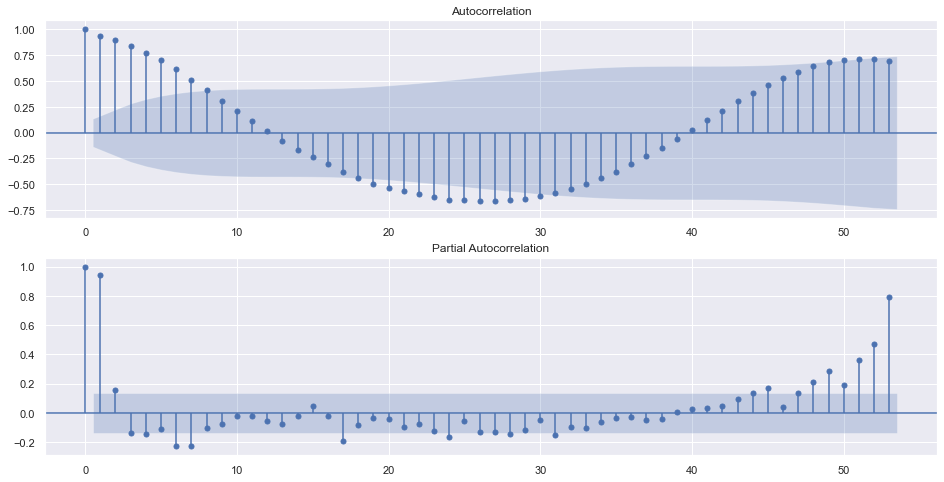

In [23]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(trainWeekly['meantemp'], lags=53, ax=ax[0])
plot_pacf(trainWeekly['meantemp'], lags=53, ax=ax[1])

plt.show()

C:\Users\vicky\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


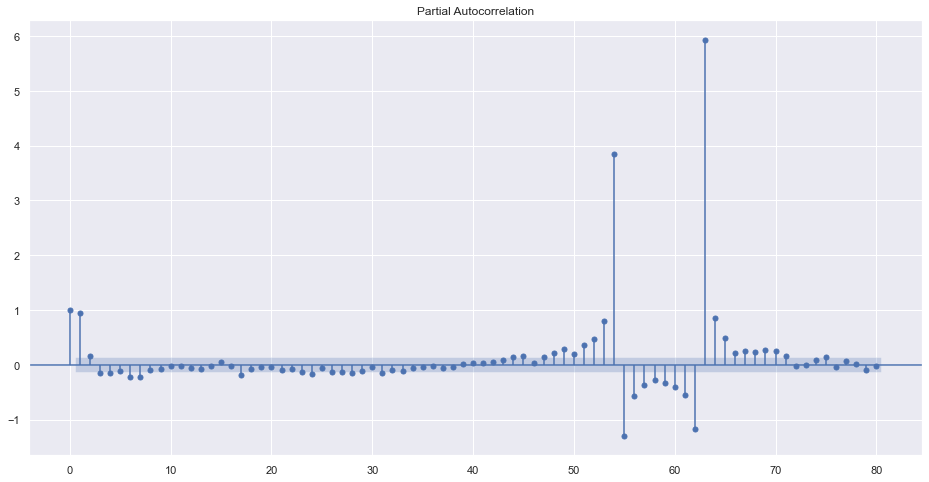

In [24]:
f, ax = plt.subplots(figsize=(16, 8))

plot_pacf(trainWeekly['meantemp'], lags=80, ax=ax)

plt.show()

Partial Autocorrelation shows only the first value to be definately significant (AR=1 model) and the Autocorrelation plot shows 5-7 last values to be significant(MA=5,6,7 model) followed by many values at 19-30. Also, we can clearly see seasonal AR at around 51,52,53 and 54 is definaltely an error so for now, let's keep it's value at 3. 

Lets Try fitting the rolling SARIMAX model with order=(1,0,4) {0 in d since the adfuller test showed the data is stationary} and seasonal order of (2,1,0,52) {safe values of almost all above 0.75}

In [25]:
train_data = trainWeekly['meantemp']
for i in range(17):
    model = sm.tsa.statespace.SARIMAX(train_data[i:], order=(1,0,4), seasonal_order=(2,1,0,52))
    start=time.time()
    model_fit = model.fit()
    pred = model_fit.forecast()
    stop=time.time()
    print("Time Taken for model",i+1,"is",stop-start)
    train_data=train_data.append(pred,ignore_index=True)

Time Taken for model 1 is 13.155876159667969
Time Taken for model 2 is 12.165243148803711
Time Taken for model 3 is 11.809306144714355
Time Taken for model 4 is 12.548840999603271
Time Taken for model 5 is 12.40855073928833
Time Taken for model 6 is 12.446355104446411
Time Taken for model 7 is 12.967272996902466
Time Taken for model 8 is 16.51720404624939
Time Taken for model 9 is 14.274280309677124
Time Taken for model 10 is 13.703248023986816
Time Taken for model 11 is 13.197264909744263
Time Taken for model 12 is 13.382359504699707
Time Taken for model 13 is 15.598087310791016
Time Taken for model 14 is 12.628180265426636
Time Taken for model 15 is 12.55422854423523
Time Taken for model 16 is 12.254695415496826
Time Taken for model 17 is 13.042474508285522


In [26]:
train_data[209:]

209    15.527510
210    16.018559
211    16.526047
212    18.268466
213    18.472538
214    18.096405
215    20.845060
216    21.642057
217    22.978846
218    24.227196
219    26.076499
220    27.892197
221    29.695039
222    30.000689
223    30.941214
224    33.369147
225    35.118971
dtype: float64

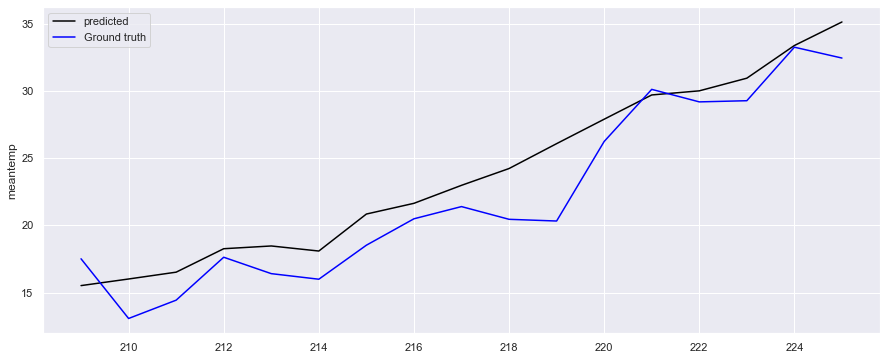

Root Mean Squared Error is 2.376232753258184


In [27]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=train_data.index[209:],y=train_data[209:], ax=ax, color='black', label='predicted')
sns.lineplot(x=train_data.index[209:],y=testWeekly['meantemp'], ax=ax, color='blue', label='Ground truth')
plt.show()
print("Root Mean Squared Error is",np.sqrt(mean_squared_error(train_data[-17:],testWeekly['meantemp'])))

Not Bad, Not Bad at all. Maybe we can reduce the error even more by changing the order values but let's look at the residuePlot for now.

<AxesSubplot:>

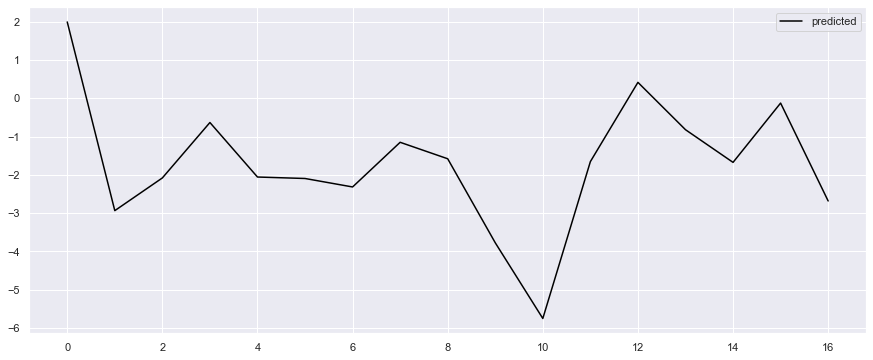

In [28]:
resid=[]
index=[]
for i in range(17):
    resid.append(testWeekly['meantemp'][i]-train_data[209+i])
    index.append(i)
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
sns.lineplot(x=index,y=resid, ax=ax, color='black', label='predicted')

We cannot see a specific pattern, So the model is not bad. Let's look at the Holt-Winters Model 

# Holt-Winters model

The Trend and Seasonality looked additive so let's start with that

In [29]:
train_data = trainWeekly['meantemp']
for i in range(17):
    hwmodel=ExponentialSmoothing(train_data[i:],trend='add',seasonal='add',seasonal_periods=52)
    start=time.time()
    result = hwmodel.fit()
    pred = result.forecast()
    stop=time.time()
    print("Time Taken for model",i+1,"is",stop-start)
    train_data=train_data.append(pred,ignore_index=True)

C:\Users\vicky\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Time Taken for model 1 is 0.16203951835632324
Time Taken for model 2 is 0.16021442413330078
Time Taken for model 3 is 0.19336390495300293
Time Taken for model 4 is 0.1989288330078125
Time Taken for model 5 is 0.17960858345031738
Time Taken for model 6 is 0.17416834831237793
Time Taken for model 7 is 0.19448208808898926
Time Taken for model 8 is 0.19269466400146484
Time Taken for model 9 is 0.20668888092041016
Time Taken for model 10 is 0.20880937576293945
Time Taken for model 11 is 0.20546245574951172
Time Taken for model 12 is 0.20120477676391602
Time Taken for model 13 is 0.19481873512268066
Time Taken for model 14 is 0.194563627243042
Time Taken for model 15 is 0.19209980964660645
Time Taken for model 16 is 0.187455415725708
Time Taken for model 17 is 0.20513582229614258


# Visulalizing the Results

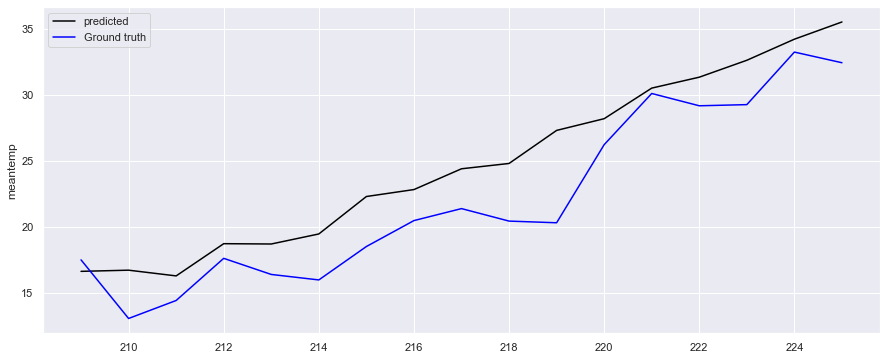

Root Mean Squared Error is 3.1008213406885066


In [30]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=train_data.index[209:],y=train_data[209:], ax=ax, color='black', label='predicted')
sns.lineplot(x=train_data.index[209:],y=testWeekly['meantemp'], ax=ax, color='blue', label='Ground truth')
plt.show()
print("Root Mean Squared Error is",np.sqrt(mean_squared_error(train_data[-17:],testWeekly['meantemp'])))

<AxesSubplot:>

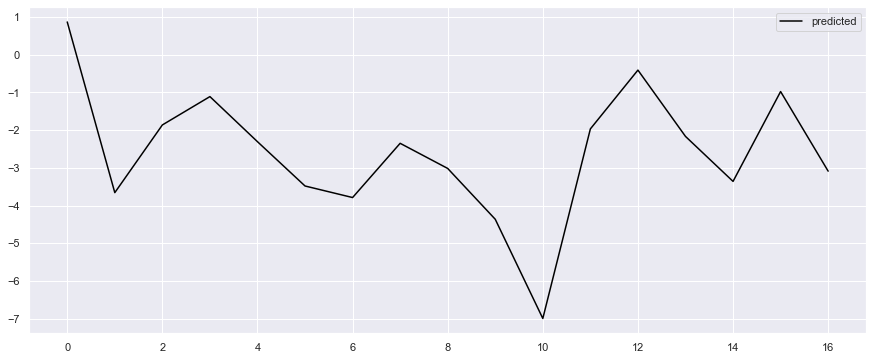

In [31]:
resid=[]
index=[]
for i in range(17):
    resid.append(testWeekly['meantemp'][i]-train_data[209+i])
    index.append(i)
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
sns.lineplot(x=index,y=resid, ax=ax, color='black', label='predicted')

This is'nt Bad either, but it's RMSE value is higher than the SARIMA Model for this testing data

Both of Them are Decent Models 